## Apple Product Sentiment Analysis

### by Monica Pecha, Sam Choe, and Daniel Fox

### Overview

This project utilized Natural Language Processing (NLP) to understand the sentiment of Apple products from the 2011 SXSW conference in Austin, Texas. The objective was to build a model that can rate the sentiment of a tweet based on its text.

### Business Understanding

Our group was hired as a data advisory group for Apple. Apple is seeking to better understand product sentiment to inform business practices, e.g., how are products recieved, how are products launched, what product issues are notable, and overall product sentiment. 

### Data Understanding and Limitations
The dataset comes from CrowdFlower via data.world. The initial dataset contains three features (tweet text, product creator, and human derived sentiment) and 9093 rows regarding both Google and Apple products. 


Limitations include that tweets focused on Apple products in relation to the SXSW conference in 2011 and may not be generalizable across non conference participants over time. After VADER sentiment analysis was implemented spot checks indicated that there were several tweets that were not classified correctly. Additionally, the synthetic data generated from ChatGPT produced some words repeatedly, more than we might expect in real life, probably introducing inflated frequencies. 

### Table of Contents
- Exploratory Data Analysis
    - Synthesizing additional data
    - Feature Engineering
    - Implementing VADER
    - Frequencies and Distribution
 - Preprocessing
    - Add stopwords, remove punctuation, lowercase all, remove numbers 
    - Tokenizing
    - Vectorizing
        - Count Vectorization
        - Term Frequency - Inverse Document Frequency (Tf-Idf) Vectorization
- Modeling and Evaluating
    - Multinomal Naive Bayes (MNB)
    - Random Forest Classifier (RFC)
    

### Exploratory Data Analysis (EDA)

In [1]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import os

from collections import Counter
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# Reading in the original dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding="ISO-8859-1")

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


ABOVE, the initial data .info shows us that we're missing the specific product (e.g, Apple, Google) in almost two-thirds of tweets. We see later that the one missing tweet_text is related to a non-Apple product and therefore not in scope for our analysis so does not need special handling. 

In [5]:
df["emotion_in_tweet_is_directed_at"].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

ABOVE, the products feature is not standardized. Below we group products into Apple and non-Apple/Google and ultimately drop non-Apple products.

In [6]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

ABOVE, the dataset starts with four sentiment/emotion categories. We regrouped the "No emotion..." and "I can't tell" into a single category. They are not equal, but we felt they were an appropriate combination.

In [7]:
# Enter differnt numbers after .iloc in [#] to spot check the text of tweets
df["tweet_text"].iloc[4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [8]:
# Defining keywords to diferentiate between Google and Apple product tweets
apple_keywords = ['iPad', 'IPad', 'iPAD', 'i-Pad', 'IPAD', 'iphone', 'iPhone', 'Iphone', 'i-phone', 'I-Phone', 'Apple', 'apple', 'Ipad', 'ipad', 'iTunes','Mac', 'IPhone', 'IPHONE']
google_keywords = ['google', 'android', 'Google', 'Android', 'samsung', 'GOOGLE', "#Android", '#android']

def find_brand(text):
    if isinstance(text, str):
        for word in apple_keywords:
            if word in text:
                return "Apple" 
        for word in google_keywords:
            if word in text:
                return "Google" 
    return 'No_Product'

df['product'] = df['tweet_text'].apply(find_brand)

In [9]:
# Reviewing new product category based on the definition created in the cell above
df['product'].value_counts()

Apple         5590
Google        2771
No_Product     732
Name: product, dtype: int64

In [10]:
# Looking for null values in 'product'
df['product'].isna().sum()

0

In [11]:
df['product'].head()

0     Apple
1     Apple
2     Apple
3     Apple
4    Google
Name: product, dtype: object

In [12]:
# Converting strings to integers and combining 'neutral'/'no emotion toward brand or product' with 'unknown'/'I can't tell'
# 0 = negative, 1 = neutral, and 2 = positive
# Renaming 'is_there_an_emotion_directed_at_a_brand_or_product' to 'emotion'
mapping = {"Positive emotion": 2, "No emotion toward brand or product": 1, "I can't tell": 1, "Negative emotion": 0}
df['emotion'] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(mapping)

In [13]:
# Reviewing new emotion category based on the definition created in the cell above
df["emotion"].value_counts()

1    5545
2    2978
0     570
Name: emotion, dtype: int64

In [14]:
# Use 1 to show all info in cell below then comment it out and use 2 to go back to default view

#1
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

#2
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [15]:
#exploring 'No_Product' tweets
filtered_df = df[df['product'] == 'No_Product']

print(filtered_df['tweet_text'])

6                                                     NaN
51      ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS...
52      ÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #s...
53      .@mention @mention on the location-based 'fast...
65      Agree. RT @mention Wait. FIONA APPLE is in tow...
                              ...                        
8932    Z6: No News is Good News {link} [codes valid: ...
8936    CLIENT NEWS! @mention Releases &quot;Dope Melo...
8970    This is my 5th year downloading the #sxsw Musi...
9024    by the way, we're looking for a spanish-speaki...
9026    True story! RT @mention I just rated Amy's Ice...
Name: tweet_text, Length: 732, dtype: object


In [16]:
# Dataframe with regrouped product and emotion categories
df2 = df[["tweet_text", "product", "emotion"]]

In [17]:
# Creating an Apple product only dataframe
df2_apple = df2[df2['product'] == "Apple"]

In [18]:
df2_apple.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1


In [19]:
df2_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5590 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5590 non-null   object
 1   product     5590 non-null   object
 2   emotion     5590 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 174.7+ KB


In [20]:
# The emotion in the dataset in not balanced
df2_apple["emotion"].value_counts(normalize=True)

1    0.540787
2    0.383721
0    0.075492
Name: emotion, dtype: float64

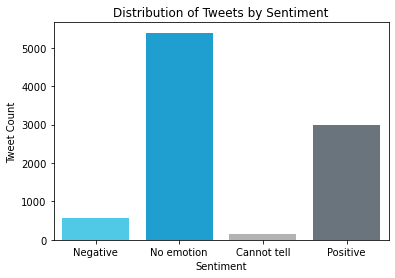

In [21]:
# Visualizing the imbalanced dataset --this is the entire initial dataset, not just Apple products
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#b3b3b3', '#66757f']

classes = ['Negative emotion', 'No emotion toward brand or product', "I can't tell", 'Positive emotion']
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Cannot tell','Positive'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig0.png', dpi=200, transparent=True)
plt.show()

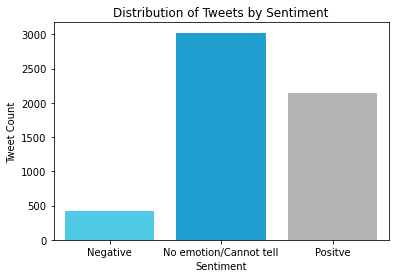

In [22]:
# Visualizing the imbalanced dataset --this is the initial dataset for Apple products only
fig, ax = plt.subplots()


classes = [0, 1, 2]
sns.countplot(x='emotion', data=df2_apple, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig1.png', dpi=200, transparent=True)
plt.show()

## This is where new EDA starts

In [23]:
df2_apple

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1
...,...,...,...
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,2
9082,#Apple guys screaming and running by line to o...,Apple,1
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,2
9088,Ipad everywhere. #SXSW {link},Apple,2


In [24]:
# Initialize VADER sentiment analyzer to predict sentiment of Apple product tweets
analyzer = SentimentIntensityAnalyzer()

# Drop NaN values or replace with empty strings 
df2_apple['tweet_text'].fillna('', inplace=True) 

# Analyze sentiment for each tweet and add the scores to the DataFrame
df2_apple['sentiment'] = df2_apple['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df2_apple['compound_score'] = df2_apple['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df2_apple['emotion2'] = df2_apple['compound_score'].apply(categorize_sentiment)

print(df2_apple[['tweet_text', 'compound_score', 'emotion', 'emotion2']])

C:\Users\monic\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


                                             tweet_text  compound_score  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...         -0.6800   
1     @jessedee Know about @fludapp ? Awesome iPad/i...          0.9100   
2     @swonderlin Can not wait for #iPad 2 also. The...          0.0000   
3     @sxsw I hope this year's festival isn't as cra...          0.7269   
5     @teachntech00 New iPad Apps For #SpeechTherapy...          0.0000   
...                                                 ...             ...   
9079  &quot;papyrus...sort of like the ipad&quot; - ...          0.8264   
9082  #Apple guys screaming and running by line to o...         -0.3818   
9085  I've always used Camera+ for my iPhone b/c it ...          0.0000   
9088                      Ipad everywhere. #SXSW {link}          0.0000   
9091  Some Verizon iPhone customers complained their...         -0.4019   

      emotion emotion2  
0           0        0  
1           2        2  
2           2        1  

<ipython-input-24-489de5ca0378>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_apple['sentiment'] = df2_apple['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))
<ipython-input-24-489de5ca0378>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_apple['compound_score'] = df2_apple['sentiment'].apply(lambda score_dict: score_dict['compound'])
<ipython-input-24-489de5ca0378>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [25]:
df2_apple.head()

,tweet_text,product,emotion,sentiment,compound_score,emotion2
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,"{'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'comp...",-0.6800,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2,"{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compou...",0.9100,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,"{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'comp...",0.7269,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1


In [26]:
# Updating the data type to an integer
df2_apple['emotion']=df2_apple['emotion'].astype(np.int64)

<ipython-input-26-bcfdac706d06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_apple['emotion']=df2_apple['emotion'].astype(np.int64)


In [27]:
# Updating the data type to an integer
df2_apple['emotion2']=df2_apple['emotion2'].astype(np.int64)

<ipython-input-27-b6f23c091ca6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_apple['emotion2']=df2_apple['emotion2'].astype(np.int64)


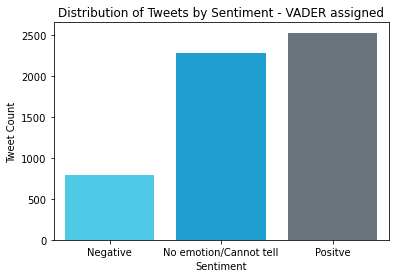

In [28]:
# # Visualizing the dataset for Apple products only - Sentiment assigned by VADER = emotion2, Sentiment assigned by human = emotion
#############MP Note - the classes are strings here, not numeric --
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#66757f']

classes = [0, 1, 2]
#classes = ["0", "1", "2"]
sns.countplot(x='emotion2', data=df2_apple, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment - VADER assigned')

plt.savefig('images/fig2.png', dpi=200, transparent=True)
plt.show()

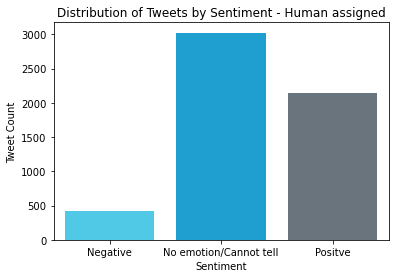

In [29]:
# # Visualizing the dataset for Apple products only - Sentiment assigned by VADER = emotion2, Sentiment assigned by human = emotion
#############MP Note - the classes are strings here, not numeric --
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#66757f']

classes = [0, 1, 2]
#classes = ["0", "1", "2"]
sns.countplot(x='emotion', data=df2_apple, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment - Human assigned')

plt.savefig('images/fig2.png', dpi=200, transparent=True)
plt.show()

In [30]:
#Sentiment assigned by VADER = emotion2, Sentiment assigned by human = emotion
df2_apple["emotion"].value_counts()

1    3023
2    2145
0     422
Name: emotion, dtype: int64

In [31]:
#Sentiment assigned by VADER = emotion2, Sentiment assigned by human = emotion
df2_apple["emotion2"].value_counts()

2    2525
1    2280
0     785
Name: emotion2, dtype: int64

In [32]:
# Clean up dataset to only include tweet text and emotion
columns_to_drop = ['sentiment', 'compound_score', 'product']
df2_apple.drop(columns=columns_to_drop, inplace=True)

C:\Users\monic\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
df2_apple.head()

,tweet_text,emotion,emotion2
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2,2
2,@swonderlin Can not wait for #iPad 2 also. The...,2,1
3,@sxsw I hope this year's festival isn't as cra...,0,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,1,1


### Word Frequencies by Sentiment

In [34]:
#creating separate datasets for each sentiment
df2_apple_pos = df2_apple[df2_apple['emotion'] == 2]
df2_apple_neutral = df2_apple[df2_apple['emotion'] == 1]
df2_apple_neg = df2_apple[df2_apple['emotion'] == 0]

### Positive Sentiment

In [35]:
# Defining X and y for positve sentiment in the human assigned emotion
X = df2_apple_pos["tweet_text"]
y = df2_apple_pos["emotion"]

In [36]:
sw = stopwords.words('english')

In [37]:
# Adding stopwords based on the dataset
sw.extend(["apple", "amp", "quot", "sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [38]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [39]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [40]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [41]:
token_tweets

['jessedee fludapp awesome ipad iphone app likely appreciate design also give free t',
 'swonderlin wait ipad also sale',
 'beautifully smart simple idea madebymany thenextweb write hollergram ipad app http bit ly ieavob',
 'counting day plus strong canadian dollar mean stock gear',
 'great ipad app madebymany http tinyurl com nqv l',
 'haha awesomely rad ipad app madebymany http bit ly htdfim hollergram',
 'added flight planely match people plane airport also download klm iphone app nicely do',
 'must app malbonster lovely review forbes ipad app holler gram http co g gzypv',
 'buy ipad austin sure q austin store',
 'oh god app ipad pure unadulterated awesome easy browse event ipad website',
 'photo instal iphone app really nice http tumblr com x pi av',
 'laurieshook look forward smcdallas pre party wed hop win ipad result shameless promotion chevysmc',
 'haha awesomely rad ipad app madebymany http bit ly htdfim hollergram michaelpiliero',
 'sq look like go rock update iphone android 

In [42]:
#Instantiating Count Vectorizer
cv = CountVectorizer()

In [43]:
# Fitting and transforming
X_vec_pos = cv.fit_transform(token_tweets)
X_vec_pos = pd.DataFrame.sparse.from_spmatrix(X_vec_pos)
X_vec_pos.columns = sorted(cv.vocabulary_)
X_vec_pos.set_index(y.index, inplace=True)

In [44]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [45]:
word_frequencies = X_vec_pos.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(55)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
ipad             1249
store             557
iphone            551
app               319
austin            268
pop               215
open              170
win               133
get               109
launch            105
cool              101
free               91
temporary          89
downtown           86
time               86
like               86
love               82
great              82
popup              77
come               77
go                 73
awesome            72
make               68
good               66
apps               65
look               65
buy                64
check              63
set                61
take               59
want               59
android            59
case               56
sell               54
video              54
first              54
today              53
shop               52
wait               50
show               49
people             49
design             49
begin              47
thanks    

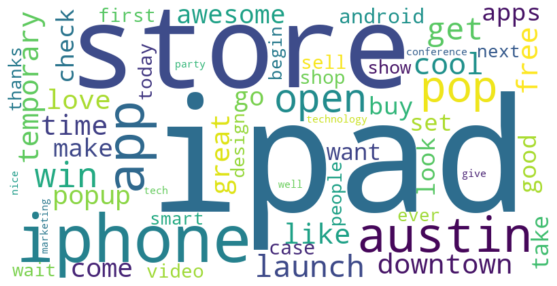

In [46]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

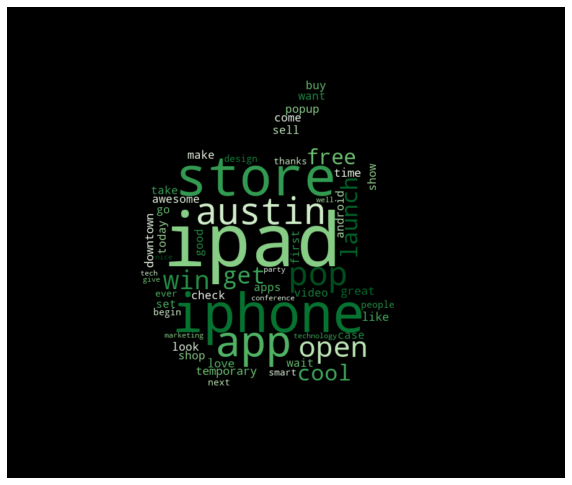

In [47]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'Greens'

current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='black', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Neutral Sentiment

In [48]:
# Defining X and y for neutral sentiment in the human assigned emotion
X = df2_apple_neutral["tweet_text"]
y = df2_apple_neutral["emotion"]

In [49]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [50]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [51]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [52]:
token_tweets

['teachntech ipad apps speechtherapy communication showcased conference http ht ly n iear edchat asd',
 'holler gram ipad itunes app store http co kfn f q marc ken',
 'anyone want sell old ipad',
 'anyone buy ipad want sell old ipad',
 'spin play concept music discovery ipad spin com itunes',
 'vatornews google force print medium evolve',
 'hootsuite hootsuite mobile update iphone blackberry android whether get friend',
 'hey long think take u make iphone case answer use zazzlesxsw make',
 'mashable ipad take video ipad gadget',
 'pad ubersocial iphone app store include uberguide sponsor',
 'khoi vinh say conde nast headlong rush ipad publishing fundamental misunderstanding platform',
 'check holler gram ipad app',
 'kawasaki talk enchant know stuff book internet',
 'smile think pop store austin lot interest actually pop',
 'ipad droid mac agnerd confession use laptop ipad blackberry follow',
 'nice open popup store ipad launch downtown austin',
 'wonder flashmob tcrn ch fcs j ipad',
 

In [53]:
#Instantiating Count Vectorizer
cv = CountVectorizer()

In [54]:
# Fitting and transforming
X_vec_neutral = cv.fit_transform(token_tweets)
X_vec_neutral = pd.DataFrame.sparse.from_spmatrix(X_vec_neutral)
X_vec_neutral.columns = sorted(cv.vocabulary_)
X_vec_neutral.set_index(y.index, inplace=True)

In [55]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [56]:
word_frequencies = X_vec_neutral.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(55)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
ipad             1550
store             900
iphone            876
austin            518
pop               374
open              314
app               275
temporary         171
android           148
free              144
launch            141
win               137
popup             130
downtown          130
design            128
get               103
go                100
set               100
today              99
mobile             92
make               91
shop               90
like               86
apps               82
time               82
check              80
game               78
congress           76
look               76
people             74
tech               73
take               72
buy                71
anyone             70
rumor              69
sell               69
talk               67
find               67
show               67
blackberry         66
itunes             64
first              63
japan              61
give      

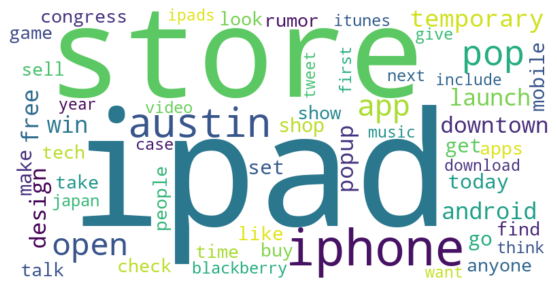

In [57]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

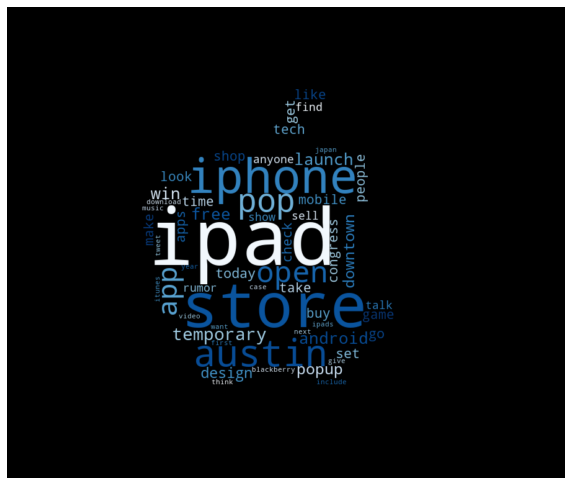

In [58]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'Blues'

current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='black', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Sentiment

In [59]:
# Defining X and y for negative sentiment in the human assigned emotion
X = df2_apple_neg["tweet_text"]
y = df2_apple_neg["emotion"]

In [60]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [61]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [62]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [63]:
token_tweets

['wesley g iphone hr tweet rise austin dead upgrade plugin station',
 'hope year festival crashy year iphone app',
 'noticed dst come weekend many iphone user hour late sunday morning iphone',
 'store insane',
 'attend ipad design headache',
 'boooo flipboard develop iphone version android say',
 'provide iphone charger change mind go next year',
 'dataviz translate satanic iphone sayin',
 'seriously test mobile apps constant ipad crash cause lose schedule sync wp',
 'ipad conflagration doofusness',
 'spent already use ipad wait couple city block ipad',
 'ipad see wild people fast still pic terrible',
 'iphone alarm botch timechange many er freak late flight miss panel behind bloody mary',
 'meant also wish dyac stupid iphone',
 'find app kyping iphone geolocation release background patch batterykiller',
 'course build temp store austin texas understand concept corral cattle pickmeupanipad',
 'open temporary store downtown austin ipad launch oh yay traffic',
 'store mall sunday x crowd

In [64]:
#Instantiating Count Vectorizer
cv = CountVectorizer()

In [65]:
# Fitting and transforming
X_vec_neg = cv.fit_transform(token_tweets)
X_vec_neg = pd.DataFrame.sparse.from_spmatrix(X_vec_neg)
X_vec_neg.columns = sorted(cv.vocabulary_)
X_vec_neg.set_index(y.index, inplace=True)

In [66]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [67]:
word_frequencies = X_vec_neg.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(55)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
ipad              211
iphone            166
app                52
store              47
like               37
design             30
austin             27
apps               26
people             24
take               21
think              20
look               20
news               18
battery            17
pop                17
headache           17
time               17
good               15
tweet              15
get                15
america            15
company            14
thing              14
give               14
long               14
fascist            14
go                 13
say                13
fail               13
back               13
talk               13
money              13
phone              13
make               13
tapworthy          12
want               12
fast               12
year               12
wait               12
japan              11
every              10
hate               10
mobile             10
nothing   

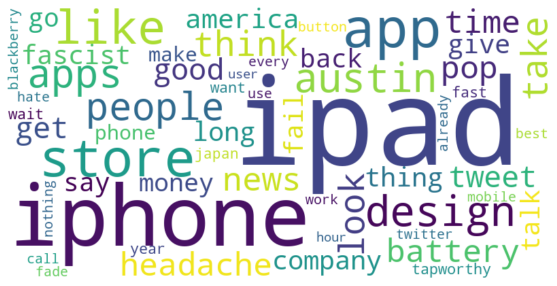

In [68]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

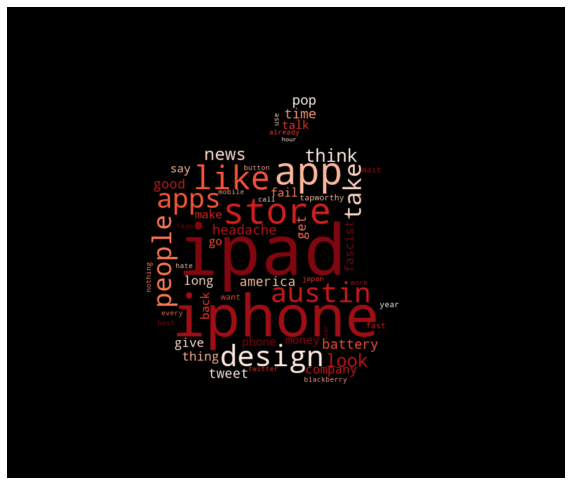

In [69]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'Reds'

current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='black', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Adding synthetic data

To address the "emotion" feature class inbalance we attempted to scrape down tweets from Twitter about Apple products with negative sentiment. The code for this process can be found in the Twitter_scraping_template notebook found in the GitHub repo Apple Product Sentiment Analysis. The scraping was unsuccessful due to access issues:

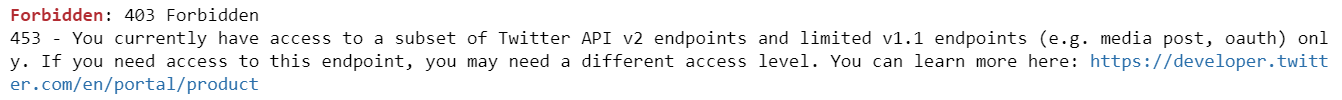

In [70]:
# In order to address the class imbalance we generated tweets with negative sentiment regarding Apple products using ChatGPT
df_new_tweets = pd.read_excel("data/Tweets_SyntheticGeneration_20240503.xlsx")

In [71]:
# The new ChatGPT tweets dataframe
df_new_tweets

,Unnamed: 0,Unnamed: 1
0,"1. ""Bought the latest iPhone, and it's already...","""Bought the latest iPhone, and it's already g..."
1,"1. ""Just got the new iPhone, and it's already ...",NaN
2,"1. ""Just tried out the original iPhone... what...",NaN
3,"1. ""Just tried the iPad 2 at #SXSW... disappoi...",NaN
4,"1. ""The iPod Nano 3rd Generation was a disappo...",NaN
...,...,...
1763,"846. ""The iPod Classic's interface is outdated...",NaN
1764,"847. ""Tried the MacBook... heavy, outdated, an...",NaN
1765,"848. ""The iPod Shuffle's lack of screen and co...",NaN
1766,"849. ""Just saw the iPhone 4... reception issue...",NaN


In [72]:
# Naming the new tweets dataframe columns
df_new_tweets.columns = ['tweet_text', 'extra_col']

In [73]:
# ChatGPT generated several duplicate tweets that we then removed from the dataset
df_new_tweets_clean = df_new_tweets.drop_duplicates(subset='tweet_text')

In [74]:
df_new_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1719 non-null   object
 1   extra_col   1 non-null      object
dtypes: object(2)
memory usage: 40.3+ KB


In [75]:
df_new_tweets_clean['product'] = 'Apple'

<ipython-input-75-55661c2f5466>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['product'] = 'Apple'


In [76]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"1. ""Bought the latest iPhone, and it's already...","""Bought the latest iPhone, and it's already g...",Apple
1,"1. ""Just got the new iPhone, and it's already ...",NaN,Apple
2,"1. ""Just tried out the original iPhone... what...",NaN,Apple
3,"1. ""Just tried the iPad 2 at #SXSW... disappoi...",NaN,Apple
4,"1. ""The iPod Nano 3rd Generation was a disappo...",NaN,Apple


In [77]:
# Define a regular expression pattern to match any number followed by a period and a space
pattern = r'^\d+\.\s'

In [78]:
# Need to remove the numbers in front of the tweets
df_new_tweets_clean['tweet_text'][3]

'1. "Just tried the iPad 2 at #SXSW... disappointed doesn\'t even begin to describe it. Same old design, same old issues. #iPad2 #letdown"'

In [79]:
# Iterate through the dataframe column and remove the matching pattern using regex
df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))

<ipython-input-79-4be8770b532e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))


In [80]:
# Initialize VADER sentiment analyzer to predict sentiment of Apple product tweets
analyzer = SentimentIntensityAnalyzer()

# Drop NaN values or replace with empty strings 
df_new_tweets_clean['tweet_text'].fillna('', inplace=True) 

# Analyze sentiment for each tweet and add the scores to the DataFrame
df_new_tweets_clean['sentiment'] = df_new_tweets_clean['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df_new_tweets_clean['compound_score'] = df_new_tweets_clean['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df_new_tweets_clean['emotion2'] = df_new_tweets_clean['compound_score'].apply(categorize_sentiment)

print(df_new_tweets_clean[['tweet_text', 'compound_score', 'emotion2']])

                                             tweet_text  compound_score  \
0     "Bought the latest iPhone, and it's already gl...         -0.5255   
1     "Just got the new iPhone, and it's already cra...         -0.6588   
2     "Just tried out the original iPhone... what a ...         -0.8356   
3     "Just tried the iPad 2 at #SXSW... disappointe...         -0.4767   
4     "The iPod Nano 3rd Generation was a disappoint...         -0.9300   
...                                                 ...             ...   
1763  "The iPod Classic's interface is outdated. Tim...          0.0000   
1764  "Tried the MacBook... heavy, outdated, and not...         -0.5812   
1765  "The iPod Shuffle's lack of screen and control...         -0.6369   
1766  "Just saw the iPhone 4... reception issues are...         -0.5209   
1767  "The iPad 2 is a disappointment. Expected more...         -0.3892   

     emotion2  
0           0  
1           0  
2           0  
3           0  
4           0  
...

C:\Users\monic\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-80-32cc879ea17c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['sentiment'] = df_new_tweets_clean['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))
<ipython-input-80-32cc879ea17c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [81]:
# Dropping unnecessary columns 
columns_to_drop = ['extra_col', 'product', 'sentiment', 'compound_score']
df_new_tweets_clean.drop(columns=columns_to_drop, inplace=True)

C:\Users\monic\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [82]:
df_new_tweets_clean.head()

,tweet_text,emotion2
0,"""Bought the latest iPhone, and it's already gl...",0
1,"""Just got the new iPhone, and it's already cra...",0
2,"""Just tried out the original iPhone... what a ...",0
3,"""Just tried the iPad 2 at #SXSW... disappointe...",0
4,"""The iPod Nano 3rd Generation was a disappoint...",0


In [83]:
df2_apple = df2_apple.drop(columns=["emotion"])

In [84]:
df2_apple.head()

,tweet_text,emotion2
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,1


In [85]:
df_combo = pd.concat([df2_apple, df_new_tweets_clean], axis=0)

In [86]:
df_combo.head()

,tweet_text,emotion2
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,1


In [87]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7309 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  7309 non-null   object
 1   emotion2    7309 non-null   object
dtypes: object(2)
memory usage: 171.3+ KB


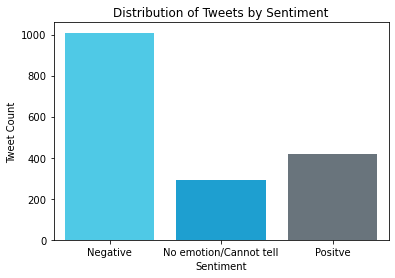

In [88]:
# # Visualizing the combined dataset (initial and synthetic texts) for Apple products only - Sentiment assigned by VADER
#############MP Note - the classes are strings here, not numeric --
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#66757f']

#classes = [0, 1, 2]
classes = ["0", "1", "2"]
sns.countplot(x='emotion2', data=df_combo, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig2.png', dpi=200, transparent=True)
plt.show()

In [89]:
df_combo["emotion2"].value_counts()

2    2525
1    2280
0    1009
0     785
2     419
1     291
Name: emotion2, dtype: int64

In [90]:
# Updating the data type to an integer
df_combo['emotion2']=df_combo['emotion2'].astype(np.int64)

In [91]:
# Sampling 1500 tweets from each of the three sentiment category
df_combo_neg_sample = df_combo[df_combo['emotion2'] == 0].sample(n=1500)
df_combo_neutral_sample = df_combo[df_combo['emotion2'] == 1].sample(n=1500)
df_combo_pos_sample = df_combo[df_combo['emotion2'] == 2].sample(n=1500)

In [92]:
df_combo_neg_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 7283 to 418
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1500 non-null   object
 1   emotion2    1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.2+ KB


In [93]:
df_combo_neutral_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 410 to 7015
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1500 non-null   object
 1   emotion2    1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.2+ KB


In [94]:
df_combo_pos_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 3019 to 5393
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1500 non-null   object
 1   emotion2    1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.2+ KB


In [95]:
# Recombining the three sentiment datasets into a single balanced dataset
df_combo_sample = pd.concat([df_combo_neg_sample, df_combo_neutral_sample, df_combo_pos_sample], axis=0)

In [96]:
df_combo_sample.head()

,tweet_text,emotion2
7283,How to know you're a geek #16162: when you cro...,0
1589,"""The MacBook Pro is a disappointment. Overheat...",0
1201,Some dude thought my buddy figured out how to...,0
1628,"""Thought the iPod Touch would be a gaming powe...",0
8346,Mint.com Talks Mobile App Development Challeng...,0


In [97]:
df_combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 7283 to 5393
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  4500 non-null   object
 1   emotion2    4500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 105.5+ KB


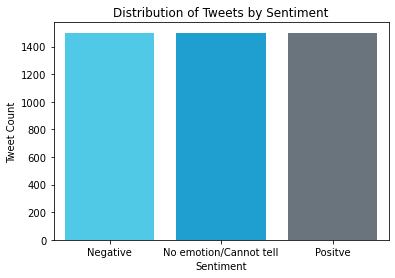

In [98]:
# Balanced distribution of sentiment for Apple products
fig, ax = plt.subplots()

classes = [0, 1, 2]

custom_palette = ['#36d8ff', '#00acee', '#66757f']
sns.countplot(x='emotion2', data=df_combo_sample, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig3.png', dpi=200, transparent=True)
plt.show()

In [99]:
df_combo_sample['emotion2'].value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: emotion2, dtype: float64

In [100]:
df_combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 7283 to 5393
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  4500 non-null   object
 1   emotion2    4500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 265.5+ KB


### Train Test Split for Modeling and Pre Processing

Our inital dataset at the beginning of this notebook reviewed tweets manually by people and were assigned sentiment based on their interpretation. While we find that this is possibly the most accurate and precise method it is not a practical model for large data. Below we begin looking at  models to determine the best methods to predict sentiment of tweets about Apple products.

In [101]:
# Defining X and y
X=df_combo_sample["tweet_text"]
y=df_combo_sample["emotion2"]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [103]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [104]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [105]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [106]:
token_tweets

['join actsofsharing com start tonight person friend city end win ipad',
 'get ready instal iphone woot',
 'online first ipad wild',
 'try macbook heavy outdated worth investment macbook disappoint',
 'open pop store downtown austin ipad launch',
 'tried ipod shuffle rd gen voiceover control trouble worth ipodshuffle disappointed',
 'ipad disappointment expect well ipad letdown',
 'leave white iphone g cab austin internet please help',
 'gotta take advantage hipster head somehow',
 'airpods battery life shorter morning commute shortbatterylife',
 'flap loose peeked look like store built',
 'anybody trouble download pak app iphone',
 'iphone camera feature gimmick real improvement fancy trick applecameras disappoint',
 'icloud storage full apparently memories worth save thanks icloudinadequacy',
 'ipad acquire thanks perserverance vote husband year check',
 'wonder many ipad sell',
 'think ipod touch revolutionary drain battery life ipodtouch disappointed',
 'tried ipod shuffle rd gen s

We are beginnng with a Count Vectorizer because we are most interested in overall counts and less concerned about weighting words that are unique throughout the entire dataset.

In [107]:
X_train.head()

5989    RT @mention Here it is! Join actsofsharing.com...
2781    Getting ready for #sxsw by installing @mention...
2765    Now online: First iPad 2 in the Wild at #SXSW ...
484     "Tried the MacBook... heavy, outdated, and not...
5432    RT @mention Apple is opening up a pop-up store...
Name: tweet_text, dtype: object

In [108]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [109]:
# Fitting and transforming the X_train
X_train_vec = cv.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [110]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [111]:
# Transforming the X_test
X_test_vec = cv.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [112]:
X_train_vec.head()

,aapl,aaron,aarpbulletin,ab,abandon,ability,able,abnormal,absolutely,absolutley,...,zazzlsxsw,zero,zip,zite,zms,zombie,zomg,zoom,zynga,zzzs
5989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model 1. We started with a Multinomial Naive Bayes (MNB) model on the Count Vectorized data. MNB is efficient and speedy with large datasets and a good test classifier.

In [113]:
# Instantiating a Multinomial Naive Bayes model
mnb = MultinomialNB()

In [114]:
# Fitting the vectorized X and y train data to the model
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [115]:
# Predicting the y from the vectorized X_test data
y_pred=mnb.predict(X_test_vec)

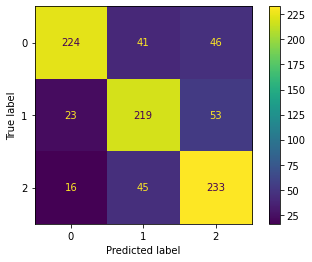

In [116]:
# Create and plot a confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test );

In [117]:
# Additional model evaluation
accuracy_score(y_test, y_pred)

0.7511111111111111

In [118]:
# Additional model evaluation
precision_score(y_test, y_pred, average='weighted')

0.7589256963443543

In [119]:
# Additional model evaluation
recall_score(y_test, y_pred, average='weighted')

0.7511111111111111

In [120]:
# Determine the most common words in the dataset
word_frequencies = X_train_vec.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(30)

# Print the most common words and their frequencies
print(most_common_words)

              Frequency
Word                   
ipad               1538
iphone             1081
store               727
austin              379
app                 301
pop                 277
letdown             264
macbook             248
disappoint          242
ipod                223
open                222
design              192
make                155
like                151
think               140
time                129
screen              126
get                 122
temporary           117
win                 112
battery             108
popup               107
free                107
try                 105
lack                105
launch              105
android             104
outdated             97
worth                97
disappointed         96


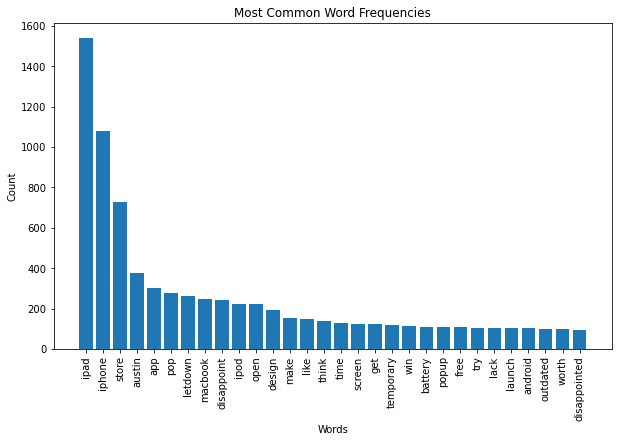

In [121]:
# Visaulize the most common words
most_common_words = word_frequencies_df.head(30)
words = most_common_words.index
counts = most_common_words['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most Common Word Frequencies')
plt.xticks(rotation=90)
plt.show()

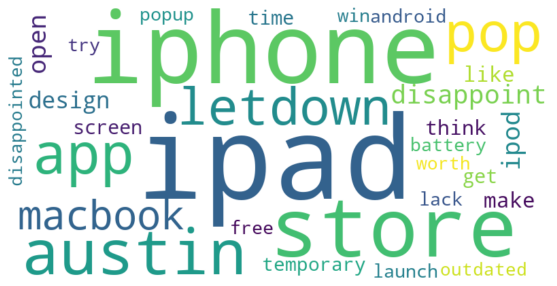

In [122]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We explored a TF-IDF Vectorizer to look at the impact of weighting more unique words across the dataset.  

In [123]:
# Instantiating the TF-IDF Vectorizer
tfidf = TfidfVectorizer()

In [124]:
# Fitting and transforming the X_train
X_train_vec_tfidf = tfidf.fit_transform(token_tweets)
X_train_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_vec_tfidf)
X_train_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_train_vec_tfidf.set_index(y_train.index, inplace=True)

In [125]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [126]:
# Transforming the X_test
X_test_vec_tfidf = tfidf.transform(token_tweets_test)
X_test_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_vec_tfidf)
X_test_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_test_vec_tfidf.set_index(y_test.index, inplace=True)

In [127]:
X_train_vec_tfidf.head()

,aapl,aaron,aarpbulletin,ab,abandon,ability,able,abnormal,absolutely,absolutley,...,zazzlsxsw,zero,zip,zite,zms,zombie,zomg,zoom,zynga,zzzs
5989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Model 2. We next ran another MNB model, but this time on the TF_IDF Vectorized data. MNB is efficient and speedy with large datasets and a good test classifier.

In [128]:
# Instantiating a Multinomial Naive Bayes model
mnb2 = MultinomialNB()

In [129]:
# Fitting the vectorized X and y train data to the model
mnb2.fit(X_train_vec_tfidf, y_train)

MultinomialNB()

In [130]:
# Predicting the y from the vectorized X_test data
y_pred2=mnb2.predict(X_test_vec_tfidf)

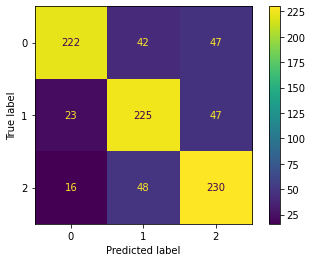

In [131]:
# Create and plot a confusion matrix to evaluate model performance
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(mnb2, X_test_vec_tfidf, y_test );

In [132]:
# Additional model evaluation
accuracy_score(y_test, y_pred2)

0.7522222222222222

In [133]:
# Additional model evaluation
precision_score(y_test, y_pred2, average='weighted')

0.7599408056113037

In [134]:
# Additional model evaluation
recall_score(y_test, y_pred2, average='weighted')

0.7522222222222222

In [135]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies_tfidf = X_train_vec_tfidf.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df2 = pd.DataFrame(word_frequencies_tfidf, columns=['Frequency'])
word_frequencies_df2.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df2 = word_frequencies_df2.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words2 = word_frequencies_df2.head(30)

# Print the most common words and their frequencies
print(most_common_words2)

               Frequency
Word                    
ipad          198.328373
iphone        150.039454
store         144.476638
austin         87.143612
pop            76.063500
open           67.330541
letdown        61.873825
app            61.201563
macbook        60.399603
disappoint     57.119250
ipod           53.022472
design         46.544507
temporary      41.864590
think          37.098391
make           36.183886
launch         34.837177
like           34.532818
downtown       34.480341
popup          34.259690
win            33.680061
screen         33.222109
time           32.238454
get            31.566119
try            30.434605
disappointed   29.703952
outdated       29.342256
worth          28.084497
touch          27.650360
android        27.562712
control        27.538291


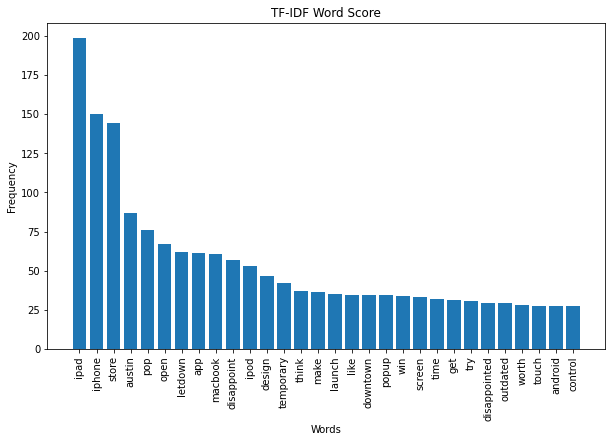

In [136]:
# Extract words and their counts from most_common_words DataFrame
most_common_words2= word_frequencies_df2.head(30)
words = most_common_words2.index
counts = most_common_words2['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('TF-IDF Word Score')
plt.xticks(rotation=90)
plt.show()

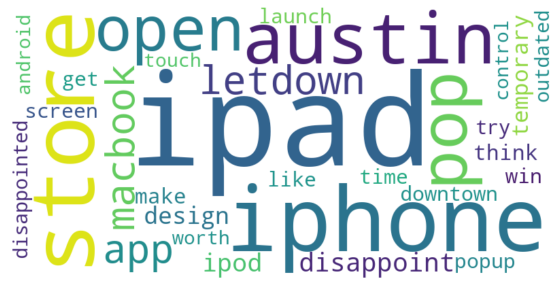

In [137]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words2['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Before running a Random Forest Classifier we created a grid search to look for the best parameters for the model.

In [138]:
# Creating a grid search to find the best hyperparameters to include in the model
grid = {'n_estimators': [500, 1000, 1500],
       'max_depth': [8, 10, 12, 14],
        'max_features': [3, 6, 9]
                }

In [139]:
# Instantiating a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

In [140]:
grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'max_features': [3, 6, 9],
                         'n_estimators': [500, 1000, 1500]},
             scoring='accuracy')

In [141]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 9, 'n_estimators': 1500}

In [142]:
grid_search.best_score_

0.7333333333333333

Model 3. In this model we ran a Random Forest Classifer (RFC), using the Count Vectorized data again. 

In [148]:
# Running the Random Forest Classifier with the best parameters from the grid search; using the count vectorized data
rf = RandomForestClassifier(n_estimators=1500, max_features=9, max_depth=14, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred = rf.predict(X_test_vec)
precision_score(y_test, y_pred, average="weighted")

0.7779104344325087

In [144]:
grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'max_features': [3, 6, 9],
                         'n_estimators': [500, 1000, 1500]},
             scoring='accuracy')

In [145]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 9, 'n_estimators': 1000}

In [146]:
grid_search.best_score_

0.73

Model 4. In this model we ran a RFC again, but this time using the TF-IDF Vectorized data again. 

In [149]:
# Running the Random Forest Classifier with the best parameters from the grid search; using the TF-IDF vectorized data
rf = RandomForestClassifier(n_estimators=1000, max_features=9, max_depth=14, random_state=42)
rf.fit(X_train_vec_tfidf, y_train)
y_pred = rf.predict(X_test_vec_tfidf)
precision_score(y_test, y_pred2, average="weighted")

0.7599408056113037

The Count Vectorized Random Forest Classifier (Model 3) has the highest ______ score. Interpret HERE. 

Monica's notes to self

- were there duplicates in the original dataset?
